<a href="https://colab.research.google.com/github/mhmod2222/SDC_Behavior_Cloning/blob/master/behavioral_cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
import ntpath
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

In [0]:
#first mount google drive from the files sidebar on the left of google colab

datadir = '/content/drive/My Drive/udacity simulator training'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', 400)
data.head()

In [0]:
data['center']= data['center'].str.split("\\").str[-1]
data['left']= data['left'].str.split("\\").str[-1]
data['right']= data['right'].str.split("\\").str[-1]
data.head()

In [0]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [0]:
print("total data", len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
print("removed", len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print("remaining", len(data))

hist, _ = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [0]:
#print(data.iloc[1])
def load_img_Steering(datadir, data):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_Steering(datadir + '/IMG', data)

In [0]:
x_train, x_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=2)
print('Training Samples: {}\nValid Samples: {}'.format(len(x_train), len(x_valid)))

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(y_train, bins=num_bins, width = 0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width = 0.05, color='red')
axes[1].set_title('Validation set')

In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

In [0]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Orignial Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

In [0]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Orignial Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [0]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

In [0]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Orignial Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered Image')

In [0]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1) # horizontal flip
  steering_angle = -steering_angle
  return image, steering_angle

In [0]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Orignial Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [0]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle

In [0]:
ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize = (15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths)-1)

  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')

In [0]:
def img_preprocess(img):
  #img = mpimg.imread(img) # use this line only with cell number 24: x_train, x_valid, and comment it when used with other cells not to get errors
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200,66))
  img = img/255
  return img

In [0]:
# you can do multi line commenting by using keyboard shortcut Ctrl+/
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[0].grid(color='white')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')
axs[1].grid(color='white')

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths)-1)

      if istraining: # training data
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else: # validation data
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [0]:
x_train_gen, y_train_gen = next(batch_generator(x_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(x_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [0]:
#x_train = np.array(list(map(img_preprocess, x_train)))
#x_valid = np.array(list(map(img_preprocess, x_valid)))

In [0]:
#plt.imshow(x_train[random.randint(0,len(x_train)-1)])
#plt.axis('off')
#print(x_train.shape)

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66,200,3), activation='elu'))
  model.add(Conv2D(36, (5, 5), strides=(2, 2), activation = 'elu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2), activation = 'elu'))
  model.add(Conv2D(64, (3, 3), activation = 'elu'))

  model.add(Conv2D(64, (3, 3), activation = 'elu'))
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(100 , activation = 'elu'))
  #model.add(Dropout(0.5))

  model.add(Dense(50, activation = 'elu'))
  #model.add(Dropout(0.5))

  model.add(Dense(10, activation = 'elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model


In [0]:
model = nvidia_model()
print(model.summary())

In [0]:
history = model.fit_generator(batch_generator(x_train, y_train, 100, 1), 
                                  steps_per_epoch=300, 
                                  epochs=20, 
                                  validation_data = batch_generator(x_valid, y_valid, 100, 0), validation_steps=200, 
                                  verbose=1, 
                                  shuffle=1)

300/300 [==============================] - 574s 2s/step - loss: 0.0998 - val_loss: 0.0569
Epoch 3/20
300/300 [==============================] - 569s 2s/step - loss: 0.0887 - val_loss: 0.0447
Epoch 4/20
300/300 [==============================] - 574s 2s/step - loss: 0.0840 - val_loss: 0.0588
Epoch 5/20
300/300 [==============================] - 576s 2s/step - loss: 0.0782 - val_loss: 0.0913
Epoch 6/20
300/300 [==============================] - 572s 2s/step - loss: 0.0766 - val_loss: 0.0396
Epoch 7/20
300/300 [==============================] - 569s 2s/step - loss: 0.0745 - val_loss: 0.0420
Epoch 8/20
300/300 [==============================] - 566s 2s/step - loss: 0.0742 - val_loss: 0.0387
Epoch 9/20
300/300 [==============================] - 572s 2s/step - loss: 0.0682 - val_loss: 0.0564
Epoch 10/20
300/300 [==============================] - 572s 2s/step - loss: 0.0681 - val_loss: 0.0346
Epoch 11/20
300/300 [==============================] - 576s 2s/step - loss: 0.0637 - val_loss: 0.0457

Text(0.5, 0, 'Epoch')

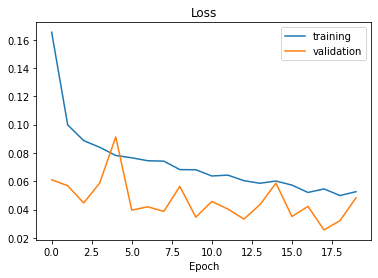

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')